**Building a strong image classification model from less data**

The implementation is a slight variation of the one in https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d

Mainly, in this kernel , the method flow(x,y) is used whereas, in the above gist, method flow_from_directory(directory) is used.
For more info, you can refer https://keras.io/preprocessing/image/

The change is made to have an appropriate kernel to deal with the way data is structured in kaggle. Appropriate changes in other parts of the source code is also done.

**Perform the necessary imports.**

In [1]:
import os, cv2, re, random
import numpy as np
import skimage.transform
import pandas as pd
# Import modules
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import random
import skimage.transform
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras import layers, models, optimizers
from keras import backend as K
from sklearn.model_selection import train_test_split

C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.applications.resnet50 import ResNet50
from keras.models       import Model
import tensorflow as tf
from keras.models       import Sequential
import keras
from keras.layers import Dense, Input
from sklearn.preprocessing import LabelEncoder
import skimage
from keras.applications.resnet50 import preprocess_input, decode_predictions


**Data dimensions and paths**

In [3]:
TRAIN_DIR = r'//192.168.5.130/Users/8nikhil/Nikhil_Banka/Keras/Cat_Dog/train/train'
TEST_DIR = 'test/'
train_images_dogs_cats = [TRAIN_DIR+'/' + i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
test_images_dogs_cats = [TEST_DIR+i for i in os.listdir(TEST_DIR)]
NO_EPOCHS=10
RESNET_WEIGHTS_PATH = '../input/keras-pretrained-models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [4]:
len(train_images_dogs_cats)

25001


**Helper function to sort the image files based on the numeric value in each file name.**

In [5]:
training_list = train_images_dogs_cats[:12400] + train_images_dogs_cats[12600:25000]

In [6]:
(len(training_list))

24800

In [8]:
val_list = train_images_dogs_cats[12400:12500] + train_images_dogs_cats[12500:12600]

**Sort the traning set. Use 1300 images each of cats and dogs instead of all 25000 to speed up the learning process.**

**Sort the test set**

In [9]:
def prepare_data(list_of_images):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    x = [] # images as arrays
    y = [] # labels
    
    for image in (list_of_images):
        x.append(cv2.resize(cv2.imread(image), (224,224), interpolation=cv2.INTER_CUBIC))
    
    for i in list_of_images:
        if 'dog' in i:
            y.append(1)
        elif 'cat' in i:
            y.append(0)
        #else:
            #print('neither cat nor dog name present in images')
            
    return np.array(x),np.array(y)

In [10]:
X_train ,Y_train = prepare_data(training_list)
X_val ,Y_val = prepare_data(val_list)


In [11]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_val = np.array(X_val)
Y_val = np.array(Y_val)


from keras.utils import to_categorical
Y_train = to_categorical(Y_train)
Y_val  = to_categorical(Y_val)

In [12]:
# Parameters 
img_size = 224
img_flat_size = img_size * img_size

# If you want to train the model -> True, otherwise -> False
Is_train = True

# If you want to load saved model -> True, otherwise -> False 
Load_model = False

# Name of the save file
save_name = 'soft1'

# Numbers of sampling to 0test the code 
num_test_sample = 20

# labels: 0 - 9
num_label = 2

# Parameters for training
num_epoch = 10

learning_rate = 1e-4
epsilon = 1e-8

batch_size = 16

# Parameter for LSTM
lstm_size = 256
step_size = 4
flatten_size = img_size

gpu_fraction = 0.3

In [13]:
# Initialize weights and bias 
def conv2d(x,w, stride):
	return tf.nn.conv2d(x,w,strides=[1, stride, stride, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

# Get Variables
def weight_variable(name, shape):
    return tf.get_variable(name,shape=shape, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(name, shape):
    return tf.get_variable(name,shape=shape, initializer=tf.contrib.layers.xavier_initializer())

In [14]:

#LSTM Variables
Wf = weight_variable('Wf', [2048 + lstm_size, lstm_size])
Wi = weight_variable('Wi', [2048 + lstm_size, lstm_size])
Wc = weight_variable('Wc', [2048 + lstm_size, lstm_size])
Wo = weight_variable('Wo', [2048 + lstm_size, lstm_size])

bf = bias_variable('bf', [lstm_size])
bi = bias_variable('bi', [lstm_size])
bc = bias_variable('bc', [lstm_size])
bo = bias_variable('bo', [lstm_size]) 

# Attention Variables
Wa = weight_variable('Wa', [2048, 1])
Wh = weight_variable('Wh', [lstm_size, 1])



In [15]:
# Soft Attention function
def soft_attention(h_prev, a, Wa, Wh):
    # h_prev: output from lstm of previous time step (shape: [batch_size, lstm_size])
    # a: Result of CNN [batch_size, conv_size * conv_size, channel_size] 

    m_list = [tf.tanh(tf.matmul(a[i], Wa) + tf.matmul(h_prev, Wh)) for i in range(len(a))] 
    m_concat = tf.concat([m_list[i] for i in range(len(a))], axis = 1)                    # (?,196)
    alpha = tf.nn.softmax(m_concat)                                                       # alpha.shape = (?,196)
    z_list = [tf.multiply(a[i], tf.slice(alpha, (0, i), (-1, 1))) for i in range(len(a))] #len(z_list) = 196
    z_stack = tf.stack(z_list, axis = 2)                                                  #(?, 512, 196)
    z = tf.reduce_sum(z_stack, axis = 2)                                                  #(?, 512)
    return alpha, z
    
    
    
    
# LSTM function
def LSTM_cell(C_prev, h_prev, x_lstm, Wf, Wi, Wc, Wo, bf, bi, bc, bo):
    
    
     #  rnn_state = C_prev
    
    
    # C_prev: Cell state from lstm of previous time step (shape: [batch_size, lstm_size])   #shape: [batch_size, 256]
    # h_prev: output from lstm of previous time step (shape: [batch_size, lstm_size])
    # x_lstm: input of lstm (shape: [batch_size, data_flatten_size])

    input_concat = tf.concat([x_lstm, h_prev], 1)           #shape=(1, 512+256),
    f = tf.sigmoid(tf.matmul(input_concat, Wf) + bf)        #shape=(1, 256),
    i = tf.sigmoid(tf.matmul(input_concat, Wi) + bi)       #shape=(1, 256), 
    c = tf.tanh(tf.matmul(input_concat, Wc) + bc)           #shape=(1, 256), 
    o = tf.sigmoid(tf.matmul(input_concat, Wo) + bo)        #shape=(1, 256), 
    
    
    C_t = tf.multiply(f, C_prev) + tf.multiply(i, c)        # shape=(1, 256), 
    h_t = tf.multiply(o, tf.tanh(C_t))                      #shape=(1, 256), 
    
    return C_t, h_t # Cell state, Output


In [16]:
x_image  = tf.placeholder(tf.float32, shape = [None, img_size,img_size, 3])
y_target = tf.placeholder(tf.float32, shape=[None, 2])

In [17]:
x= tf.keras.applications.resnet50.preprocess_input(x_image)


In [18]:
with tf.variable_scope("InceptionModel"):
    base_model = tf.keras.applications.ResNet50(weights='imagenet', pooling='max', include_top=False, input_tensor=x)     #top false. Removed last 2 layers(GlobalAveragePooling2 &dense_prediction) from full model

third_last_layer_name = base_model.layers[-3].name
third_last_layer = base_model.get_layer(third_last_layer_name).output
conv_size = third_last_layer.get_shape()[1] 
conv_flat = tf.reshape(third_last_layer, [-1, conv_size*conv_size, 2048])               # shape=(?, 196, 512) 
conv_unstack = tf.unstack(conv_flat, axis = 1)    

In [19]:


rnn_batch_size = tf.shape(x_image)[0]                                           # rnn_batch_size = 1

# Initial lstm cell state and output 
rnn_state = tf.zeros([rnn_batch_size, lstm_size], tf.float32)                         # shape=(1, 256) 
rnn_out = tf.zeros([rnn_batch_size, lstm_size], tf.float32)                            # shape=(1, 256)
 
#################################### Attention!!! ####################################
for i in range(4):
    alpha, z = soft_attention(rnn_out, conv_unstack, Wa, Wh)       
    rnn_state, rnn_out = LSTM_cell(rnn_state, rnn_out, z, Wf, Wi, Wc, Wo, bf, bi, bc, bo)

######################################################################################


In [20]:
w_fc1 = weight_variable('w_fc1',[256, 2])
b_fc1 = bias_variable('b_fc1', [2])

output = tf.matmul(rnn_out, w_fc1)+b_fc1
output = tf.nn.softmax(output)
# Training 
Loss = tf.keras.backend.categorical_crossentropy(target = y_target, output = output)
Cost = tf.reduce_mean(Loss)
optimizer = tf.train.AdamOptimizer(learning_rate =0.0001 , epsilon = epsilon).minimize(Cost)

correct_prediction = tf.equal(tf.argmax(y_target,1), tf.argmax(output,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [21]:
# Create Session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = gpu_fraction
saver = tf.train.Saver()

sess = tf.keras.backend.get_session()
initialize_variables_list = list(set(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))^set(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='InceptionModel')))
writer = tf.summary.FileWriter("output", sess.graph)
sess.run(initialize_variables_list )

[array([[ 0.13298848, -0.06229682],
        [ 0.0452857 , -0.008246  ],
        [ 0.10625315, -0.04910545],
        [-0.12068649,  0.06365812],
        [-0.04129009, -0.12800269],
        [-0.14176613,  0.10228026],
        [ 0.04958102,  0.09287341],
        [ 0.02679843, -0.03732763],
        [-0.05444397, -0.03006804],
        [-0.03336354,  0.11475232],
        [ 0.08881046,  0.11365381],
        [ 0.07872599, -0.05492965],
        [ 0.06189016, -0.02526647],
        [ 0.08947217, -0.02106771],
        [-0.11559805,  0.14870307],
        [ 0.15039122,  0.01372446],
        [ 0.13379121, -0.09003465],
        [ 0.02466884,  0.14801338],
        [-0.02099226, -0.08035176],
        [ 0.09007043, -0.02531962],
        [ 0.09303324,  0.14840049],
        [-0.01003189, -0.03652003],
        [ 0.02203698,  0.12461367],
        [-0.06143007, -0.07579361],
        [-0.03357889,  0.13074452],
        [-0.01768295,  0.03978197],
        [-0.05584552,  0.02231811],
        [ 0.1125344 , -0.006

In [22]:
# Training
batch_size=16
Is_train = True

if Is_train == True:
    train_data_num = X_train.shape[0]

    for i in range(num_epoch):
        # Making batches
        random_idx = np.arange(train_data_num)
        np.random.shuffle(random_idx)

        batch_count = 1
    
        for j in range(0, train_data_num, batch_size):
            if j + batch_size < train_data_num:
                batch_index = [j, j + batch_size]
                
                lis_batch=[]
                for k in range(16):
                    lis_batch.append(train_images_dogs_cats[random_idx[batch_index[0]:batch_index[1]]  [k]])
                
               
            else:
                
                batch_index = [j, j + train_data_num-1]
                
                lis_batch=[]
                for k in range(16):
                    lis_batch.append(train_images_dogs_cats[random_idx[batch_index[0]:batch_index[1]][k]])
                
                
                
                
            X_train,Y_train = prepare_data(lis_batch)
            batch_x_train = np.array(X_train)
            Y_train = np.array(Y_train)
            batch_y_train = to_categorical(Y_train)
            
            train_batch = np.reshape(batch_x_train, (batch_x_train.shape[0], img_size, img_size, 3))
            validation_batch = np.reshape(X_val, (X_val.shape[0], img_size, img_size, 3))
            
            # Training
            optimizer.run(session=sess, feed_dict = {x_image: train_batch, y_target: batch_y_train})
            cost = Cost.eval( session=sess, feed_dict = {x_image: train_batch, y_target: batch_y_train})
            acc = accuracy.eval( session=sess, feed_dict = {x_image: train_batch, y_target: batch_y_train})
            val_acc = accuracy.eval( session=sess, feed_dict = {x_image: X_val, y_target: Y_val})

            # Print Progress
            print("Epoch: " + str(i+1) + ' / ' + 
                  "Batch: " + str(j) + '/' + str(train_data_num) + ' / ' + 
                  "Cost: " + str(cost) + ' / ' + 
                  "Training Accuracy: " + str(acc) + ' / ' + 
                  "Validation Accuracy: " + str(val_acc))  

        #saver.save(sess, 'saved_networks1/' + save_name)
        #saver.save(sess, 'my-model', global_step=num_epoch*1000000+batch_count)

        print('Model is saved!!!')

Epoch: 1 / Batch: 0/24800 / Cost: 0.19944264 / Training Accuracy: 1.0 / Validation Accuracy: 0.72
Epoch: 1 / Batch: 16/24800 / Cost: 0.1374154 / Training Accuracy: 1.0 / Validation Accuracy: 0.76
Epoch: 1 / Batch: 32/24800 / Cost: 0.15943307 / Training Accuracy: 1.0 / Validation Accuracy: 0.73
Epoch: 1 / Batch: 48/24800 / Cost: 0.08774021 / Training Accuracy: 1.0 / Validation Accuracy: 0.74
Epoch: 1 / Batch: 64/24800 / Cost: 0.2363678 / Training Accuracy: 0.9375 / Validation Accuracy: 0.84
Epoch: 1 / Batch: 80/24800 / Cost: 0.1400173 / Training Accuracy: 1.0 / Validation Accuracy: 0.77
Epoch: 1 / Batch: 96/24800 / Cost: 0.06932854 / Training Accuracy: 1.0 / Validation Accuracy: 0.92
Epoch: 1 / Batch: 112/24800 / Cost: 0.03939791 / Training Accuracy: 1.0 / Validation Accuracy: 0.93
Epoch: 1 / Batch: 128/24800 / Cost: 0.02321915 / Training Accuracy: 1.0 / Validation Accuracy: 0.935
Epoch: 1 / Batch: 144/24800 / Cost: 0.02389893 / Training Accuracy: 1.0 / Validation Accuracy: 0.94
Epoch: 

Epoch: 1 / Batch: 1296/24800 / Cost: 0.042208143 / Training Accuracy: 1.0 / Validation Accuracy: 0.9
Epoch: 1 / Batch: 1312/24800 / Cost: 0.37942734 / Training Accuracy: 0.8125 / Validation Accuracy: 0.88
Epoch: 1 / Batch: 1328/24800 / Cost: 0.18733889 / Training Accuracy: 0.875 / Validation Accuracy: 0.86
Epoch: 1 / Batch: 1344/24800 / Cost: 0.07386776 / Training Accuracy: 1.0 / Validation Accuracy: 0.89
Epoch: 1 / Batch: 1360/24800 / Cost: 0.054414157 / Training Accuracy: 1.0 / Validation Accuracy: 0.905
Epoch: 1 / Batch: 1376/24800 / Cost: 0.11500184 / Training Accuracy: 0.9375 / Validation Accuracy: 0.94
Epoch: 1 / Batch: 1392/24800 / Cost: 0.07052733 / Training Accuracy: 1.0 / Validation Accuracy: 0.915
Epoch: 1 / Batch: 1408/24800 / Cost: 0.4080832 / Training Accuracy: 0.875 / Validation Accuracy: 0.885
Epoch: 1 / Batch: 1424/24800 / Cost: 0.3087802 / Training Accuracy: 0.8125 / Validation Accuracy: 0.895
Epoch: 1 / Batch: 1440/24800 / Cost: 0.09444615 / Training Accuracy: 0.9375

Epoch: 1 / Batch: 2576/24800 / Cost: 0.01749112 / Training Accuracy: 1.0 / Validation Accuracy: 0.935
Epoch: 1 / Batch: 2592/24800 / Cost: 0.038534757 / Training Accuracy: 1.0 / Validation Accuracy: 0.94
Epoch: 1 / Batch: 2608/24800 / Cost: 0.07383176 / Training Accuracy: 0.9375 / Validation Accuracy: 0.95
Epoch: 1 / Batch: 2624/24800 / Cost: 0.04625327 / Training Accuracy: 1.0 / Validation Accuracy: 0.95
Epoch: 1 / Batch: 2640/24800 / Cost: 0.059841022 / Training Accuracy: 1.0 / Validation Accuracy: 0.95
Epoch: 1 / Batch: 2656/24800 / Cost: 0.05714353 / Training Accuracy: 1.0 / Validation Accuracy: 0.94
Epoch: 1 / Batch: 2672/24800 / Cost: 0.08000056 / Training Accuracy: 1.0 / Validation Accuracy: 0.915
Epoch: 1 / Batch: 2688/24800 / Cost: 0.15850234 / Training Accuracy: 0.9375 / Validation Accuracy: 0.9
Epoch: 1 / Batch: 2704/24800 / Cost: 0.12243189 / Training Accuracy: 0.9375 / Validation Accuracy: 0.9
Epoch: 1 / Batch: 2720/24800 / Cost: 0.01918479 / Training Accuracy: 1.0 / Valid

Epoch: 1 / Batch: 3856/24800 / Cost: 0.019654255 / Training Accuracy: 1.0 / Validation Accuracy: 0.97
Epoch: 1 / Batch: 3872/24800 / Cost: 0.0036839135 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 3888/24800 / Cost: 0.0144652445 / Training Accuracy: 1.0 / Validation Accuracy: 0.98
Epoch: 1 / Batch: 3904/24800 / Cost: 0.003640714 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 3920/24800 / Cost: 0.0565318 / Training Accuracy: 1.0 / Validation Accuracy: 0.97
Epoch: 1 / Batch: 3936/24800 / Cost: 0.068222076 / Training Accuracy: 0.9375 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 3952/24800 / Cost: 0.058489565 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 3968/24800 / Cost: 0.015852468 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 3984/24800 / Cost: 0.19085065 / Training Accuracy: 0.9375 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 4000/24800 / Cost: 0.13628843 / Training Accuracy: 0.

Epoch: 1 / Batch: 5136/24800 / Cost: 0.10459371 / Training Accuracy: 0.9375 / Validation Accuracy: 0.945
Epoch: 1 / Batch: 5152/24800 / Cost: 0.047616005 / Training Accuracy: 0.9375 / Validation Accuracy: 0.96
Epoch: 1 / Batch: 5168/24800 / Cost: 0.0029919979 / Training Accuracy: 1.0 / Validation Accuracy: 0.97
Epoch: 1 / Batch: 5184/24800 / Cost: 0.03240987 / Training Accuracy: 1.0 / Validation Accuracy: 0.97
Epoch: 1 / Batch: 5200/24800 / Cost: 0.014683452 / Training Accuracy: 1.0 / Validation Accuracy: 0.98
Epoch: 1 / Batch: 5216/24800 / Cost: 0.005289728 / Training Accuracy: 1.0 / Validation Accuracy: 0.98
Epoch: 1 / Batch: 5232/24800 / Cost: 0.00303604 / Training Accuracy: 1.0 / Validation Accuracy: 0.98
Epoch: 1 / Batch: 5248/24800 / Cost: 0.056335136 / Training Accuracy: 1.0 / Validation Accuracy: 0.98
Epoch: 1 / Batch: 5264/24800 / Cost: 0.014318246 / Training Accuracy: 1.0 / Validation Accuracy: 0.98
Epoch: 1 / Batch: 5280/24800 / Cost: 0.0160602 / Training Accuracy: 1.0 / Val

Epoch: 1 / Batch: 6416/24800 / Cost: 0.042268887 / Training Accuracy: 1.0 / Validation Accuracy: 0.96
Epoch: 1 / Batch: 6432/24800 / Cost: 0.017028512 / Training Accuracy: 1.0 / Validation Accuracy: 0.945
Epoch: 1 / Batch: 6448/24800 / Cost: 0.050642543 / Training Accuracy: 1.0 / Validation Accuracy: 0.945
Epoch: 1 / Batch: 6464/24800 / Cost: 0.027539626 / Training Accuracy: 1.0 / Validation Accuracy: 0.945
Epoch: 1 / Batch: 6480/24800 / Cost: 0.07802127 / Training Accuracy: 1.0 / Validation Accuracy: 0.965
Epoch: 1 / Batch: 6496/24800 / Cost: 0.042605445 / Training Accuracy: 1.0 / Validation Accuracy: 0.955
Epoch: 1 / Batch: 6512/24800 / Cost: 0.02730663 / Training Accuracy: 1.0 / Validation Accuracy: 0.94
Epoch: 1 / Batch: 6528/24800 / Cost: 0.00766432 / Training Accuracy: 1.0 / Validation Accuracy: 0.935
Epoch: 1 / Batch: 6544/24800 / Cost: 0.076806836 / Training Accuracy: 0.9375 / Validation Accuracy: 0.94
Epoch: 1 / Batch: 6560/24800 / Cost: 0.14285588 / Training Accuracy: 0.875 /

Epoch: 1 / Batch: 7696/24800 / Cost: 0.09966704 / Training Accuracy: 0.9375 / Validation Accuracy: 0.95
Epoch: 1 / Batch: 7712/24800 / Cost: 0.1713502 / Training Accuracy: 0.9375 / Validation Accuracy: 0.95
Epoch: 1 / Batch: 7728/24800 / Cost: 0.10780823 / Training Accuracy: 1.0 / Validation Accuracy: 0.955
Epoch: 1 / Batch: 7744/24800 / Cost: 0.06478648 / Training Accuracy: 1.0 / Validation Accuracy: 0.97
Epoch: 1 / Batch: 7760/24800 / Cost: 0.15656468 / Training Accuracy: 0.9375 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 7776/24800 / Cost: 0.07464805 / Training Accuracy: 1.0 / Validation Accuracy: 0.98
Epoch: 1 / Batch: 7792/24800 / Cost: 0.028886892 / Training Accuracy: 1.0 / Validation Accuracy: 0.96
Epoch: 1 / Batch: 7808/24800 / Cost: 0.1852765 / Training Accuracy: 0.9375 / Validation Accuracy: 0.965
Epoch: 1 / Batch: 7824/24800 / Cost: 0.030306952 / Training Accuracy: 1.0 / Validation Accuracy: 0.96
Epoch: 1 / Batch: 7840/24800 / Cost: 0.09909924 / Training Accuracy: 0.9375 

Epoch: 1 / Batch: 8976/24800 / Cost: 0.055749595 / Training Accuracy: 1.0 / Validation Accuracy: 0.92
Epoch: 1 / Batch: 8992/24800 / Cost: 0.15554303 / Training Accuracy: 0.875 / Validation Accuracy: 0.88
Epoch: 1 / Batch: 9008/24800 / Cost: 0.1618483 / Training Accuracy: 1.0 / Validation Accuracy: 0.85
Epoch: 1 / Batch: 9024/24800 / Cost: 0.15049954 / Training Accuracy: 1.0 / Validation Accuracy: 0.825
Epoch: 1 / Batch: 9040/24800 / Cost: 0.16123807 / Training Accuracy: 0.9375 / Validation Accuracy: 0.855
Epoch: 1 / Batch: 9056/24800 / Cost: 0.074049294 / Training Accuracy: 1.0 / Validation Accuracy: 0.9
Epoch: 1 / Batch: 9072/24800 / Cost: 0.056715056 / Training Accuracy: 1.0 / Validation Accuracy: 0.93
Epoch: 1 / Batch: 9088/24800 / Cost: 0.05687996 / Training Accuracy: 1.0 / Validation Accuracy: 0.95
Epoch: 1 / Batch: 9104/24800 / Cost: 0.03890828 / Training Accuracy: 1.0 / Validation Accuracy: 0.955
Epoch: 1 / Batch: 9120/24800 / Cost: 0.06835739 / Training Accuracy: 1.0 / Validat

Epoch: 1 / Batch: 10256/24800 / Cost: 0.0037379551 / Training Accuracy: 1.0 / Validation Accuracy: 0.97
Epoch: 1 / Batch: 10272/24800 / Cost: 0.022957742 / Training Accuracy: 1.0 / Validation Accuracy: 0.955
Epoch: 1 / Batch: 10288/24800 / Cost: 0.03976821 / Training Accuracy: 1.0 / Validation Accuracy: 0.945
Epoch: 1 / Batch: 10304/24800 / Cost: 0.022585774 / Training Accuracy: 1.0 / Validation Accuracy: 0.93
Epoch: 1 / Batch: 10320/24800 / Cost: 0.05686604 / Training Accuracy: 1.0 / Validation Accuracy: 0.92
Epoch: 1 / Batch: 10336/24800 / Cost: 0.117496945 / Training Accuracy: 0.9375 / Validation Accuracy: 0.925
Epoch: 1 / Batch: 10352/24800 / Cost: 0.05512378 / Training Accuracy: 1.0 / Validation Accuracy: 0.92
Epoch: 1 / Batch: 10368/24800 / Cost: 0.05496586 / Training Accuracy: 1.0 / Validation Accuracy: 0.94
Epoch: 1 / Batch: 10384/24800 / Cost: 0.04081179 / Training Accuracy: 1.0 / Validation Accuracy: 0.94
Epoch: 1 / Batch: 10400/24800 / Cost: 0.037743993 / Training Accuracy: 

Epoch: 1 / Batch: 11520/24800 / Cost: 0.056226976 / Training Accuracy: 1.0 / Validation Accuracy: 0.965
Epoch: 1 / Batch: 11536/24800 / Cost: 0.011690836 / Training Accuracy: 1.0 / Validation Accuracy: 0.955
Epoch: 1 / Batch: 11552/24800 / Cost: 0.0403879 / Training Accuracy: 1.0 / Validation Accuracy: 0.96
Epoch: 1 / Batch: 11568/24800 / Cost: 0.037364 / Training Accuracy: 1.0 / Validation Accuracy: 0.965
Epoch: 1 / Batch: 11584/24800 / Cost: 0.078494266 / Training Accuracy: 0.9375 / Validation Accuracy: 0.96
Epoch: 1 / Batch: 11600/24800 / Cost: 0.02660836 / Training Accuracy: 1.0 / Validation Accuracy: 0.955
Epoch: 1 / Batch: 11616/24800 / Cost: 0.18725277 / Training Accuracy: 0.875 / Validation Accuracy: 0.96
Epoch: 1 / Batch: 11632/24800 / Cost: 0.03847969 / Training Accuracy: 1.0 / Validation Accuracy: 0.96
Epoch: 1 / Batch: 11648/24800 / Cost: 0.039422426 / Training Accuracy: 1.0 / Validation Accuracy: 0.95
Epoch: 1 / Batch: 11664/24800 / Cost: 0.059529215 / Training Accuracy: 1

Epoch: 1 / Batch: 12784/24800 / Cost: 0.05147593 / Training Accuracy: 0.9375 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 12800/24800 / Cost: 0.050232336 / Training Accuracy: 1.0 / Validation Accuracy: 0.98
Epoch: 1 / Batch: 12816/24800 / Cost: 0.07356245 / Training Accuracy: 0.9375 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 12832/24800 / Cost: 0.07346818 / Training Accuracy: 1.0 / Validation Accuracy: 0.97
Epoch: 1 / Batch: 12848/24800 / Cost: 0.055911448 / Training Accuracy: 0.9375 / Validation Accuracy: 0.95
Epoch: 1 / Batch: 12864/24800 / Cost: 0.07415981 / Training Accuracy: 1.0 / Validation Accuracy: 0.925
Epoch: 1 / Batch: 12880/24800 / Cost: 0.092080265 / Training Accuracy: 0.9375 / Validation Accuracy: 0.925
Epoch: 1 / Batch: 12896/24800 / Cost: 0.032958075 / Training Accuracy: 1.0 / Validation Accuracy: 0.93
Epoch: 1 / Batch: 12912/24800 / Cost: 0.046358887 / Training Accuracy: 1.0 / Validation Accuracy: 0.945
Epoch: 1 / Batch: 12928/24800 / Cost: 0.04863545 / Training 

Epoch: 1 / Batch: 14048/24800 / Cost: 0.024596166 / Training Accuracy: 1.0 / Validation Accuracy: 0.955
Epoch: 1 / Batch: 14064/24800 / Cost: 0.025529495 / Training Accuracy: 1.0 / Validation Accuracy: 0.93
Epoch: 1 / Batch: 14080/24800 / Cost: 0.09195039 / Training Accuracy: 0.9375 / Validation Accuracy: 0.92
Epoch: 1 / Batch: 14096/24800 / Cost: 0.1734828 / Training Accuracy: 0.875 / Validation Accuracy: 0.89
Epoch: 1 / Batch: 14112/24800 / Cost: 0.030273214 / Training Accuracy: 1.0 / Validation Accuracy: 0.885
Epoch: 1 / Batch: 14128/24800 / Cost: 0.23641571 / Training Accuracy: 0.875 / Validation Accuracy: 0.91
Epoch: 1 / Batch: 14144/24800 / Cost: 0.056111798 / Training Accuracy: 1.0 / Validation Accuracy: 0.95
Epoch: 1 / Batch: 14160/24800 / Cost: 0.08077562 / Training Accuracy: 0.9375 / Validation Accuracy: 0.955
Epoch: 1 / Batch: 14176/24800 / Cost: 0.24607529 / Training Accuracy: 0.875 / Validation Accuracy: 0.965
Epoch: 1 / Batch: 14192/24800 / Cost: 0.12383723 / Training Acc

Epoch: 1 / Batch: 15312/24800 / Cost: 0.003895 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 15328/24800 / Cost: 0.0030674743 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 15344/24800 / Cost: 0.04374098 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 15360/24800 / Cost: 0.011805895 / Training Accuracy: 1.0 / Validation Accuracy: 0.985
Epoch: 1 / Batch: 15376/24800 / Cost: 0.00841558 / Training Accuracy: 1.0 / Validation Accuracy: 0.98
Epoch: 1 / Batch: 15392/24800 / Cost: 0.0026331407 / Training Accuracy: 1.0 / Validation Accuracy: 0.98
Epoch: 1 / Batch: 15408/24800 / Cost: 0.0076868236 / Training Accuracy: 1.0 / Validation Accuracy: 0.985
Epoch: 1 / Batch: 15424/24800 / Cost: 0.06950493 / Training Accuracy: 1.0 / Validation Accuracy: 0.985
Epoch: 1 / Batch: 15440/24800 / Cost: 0.0009627134 / Training Accuracy: 1.0 / Validation Accuracy: 0.98
Epoch: 1 / Batch: 15456/24800 / Cost: 0.0013005512 / Training Accurac

Epoch: 1 / Batch: 16592/24800 / Cost: 0.020669298 / Training Accuracy: 1.0 / Validation Accuracy: 0.995
Epoch: 1 / Batch: 16608/24800 / Cost: 0.005109738 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 16624/24800 / Cost: 0.019051045 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 16640/24800 / Cost: 0.063223794 / Training Accuracy: 1.0 / Validation Accuracy: 0.965
Epoch: 1 / Batch: 16656/24800 / Cost: 0.02161533 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 16672/24800 / Cost: 0.0033071046 / Training Accuracy: 1.0 / Validation Accuracy: 0.985
Epoch: 1 / Batch: 16688/24800 / Cost: 0.0070683924 / Training Accuracy: 1.0 / Validation Accuracy: 0.99
Epoch: 1 / Batch: 16704/24800 / Cost: 0.04321691 / Training Accuracy: 1.0 / Validation Accuracy: 0.99
Epoch: 1 / Batch: 16720/24800 / Cost: 0.015902814 / Training Accuracy: 1.0 / Validation Accuracy: 0.99
Epoch: 1 / Batch: 16736/24800 / Cost: 0.01292332 / Training Accurac

Epoch: 1 / Batch: 17872/24800 / Cost: 0.006153964 / Training Accuracy: 1.0 / Validation Accuracy: 0.985
Epoch: 1 / Batch: 17888/24800 / Cost: 0.03654767 / Training Accuracy: 1.0 / Validation Accuracy: 0.995
Epoch: 1 / Batch: 17904/24800 / Cost: 0.009180267 / Training Accuracy: 1.0 / Validation Accuracy: 0.995
Epoch: 1 / Batch: 17920/24800 / Cost: 0.12902346 / Training Accuracy: 0.9375 / Validation Accuracy: 0.99
Epoch: 1 / Batch: 17936/24800 / Cost: 0.06699804 / Training Accuracy: 1.0 / Validation Accuracy: 0.99
Epoch: 1 / Batch: 17952/24800 / Cost: 0.02525694 / Training Accuracy: 1.0 / Validation Accuracy: 0.985
Epoch: 1 / Batch: 17968/24800 / Cost: 0.040741548 / Training Accuracy: 1.0 / Validation Accuracy: 0.965
Epoch: 1 / Batch: 17984/24800 / Cost: 0.17349239 / Training Accuracy: 0.9375 / Validation Accuracy: 0.945
Epoch: 1 / Batch: 18000/24800 / Cost: 0.11385002 / Training Accuracy: 0.9375 / Validation Accuracy: 0.955
Epoch: 1 / Batch: 18016/24800 / Cost: 0.036923602 / Training Ac

Epoch: 1 / Batch: 19136/24800 / Cost: 0.005691637 / Training Accuracy: 1.0 / Validation Accuracy: 0.965
Epoch: 1 / Batch: 19152/24800 / Cost: 0.011468474 / Training Accuracy: 1.0 / Validation Accuracy: 0.96
Epoch: 1 / Batch: 19168/24800 / Cost: 0.04605659 / Training Accuracy: 1.0 / Validation Accuracy: 0.97
Epoch: 1 / Batch: 19184/24800 / Cost: 0.17457195 / Training Accuracy: 0.9375 / Validation Accuracy: 0.985
Epoch: 1 / Batch: 19200/24800 / Cost: 0.0052302633 / Training Accuracy: 1.0 / Validation Accuracy: 0.985
Epoch: 1 / Batch: 19216/24800 / Cost: 0.030907834 / Training Accuracy: 1.0 / Validation Accuracy: 0.96
Epoch: 1 / Batch: 19232/24800 / Cost: 0.12252393 / Training Accuracy: 0.9375 / Validation Accuracy: 0.92
Epoch: 1 / Batch: 19248/24800 / Cost: 0.29614982 / Training Accuracy: 0.9375 / Validation Accuracy: 0.91
Epoch: 1 / Batch: 19264/24800 / Cost: 0.21503773 / Training Accuracy: 0.9375 / Validation Accuracy: 0.93
Epoch: 1 / Batch: 19280/24800 / Cost: 0.0671994 / Training Acc

Epoch: 1 / Batch: 20400/24800 / Cost: 0.13325113 / Training Accuracy: 0.9375 / Validation Accuracy: 0.945
Epoch: 1 / Batch: 20416/24800 / Cost: 0.01615794 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 20432/24800 / Cost: 0.023671081 / Training Accuracy: 1.0 / Validation Accuracy: 0.985
Epoch: 1 / Batch: 20448/24800 / Cost: 0.07995836 / Training Accuracy: 0.9375 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 20464/24800 / Cost: 0.01876551 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 20480/24800 / Cost: 0.09529769 / Training Accuracy: 1.0 / Validation Accuracy: 0.96
Epoch: 1 / Batch: 20496/24800 / Cost: 0.05509699 / Training Accuracy: 1.0 / Validation Accuracy: 0.96
Epoch: 1 / Batch: 20512/24800 / Cost: 0.065328814 / Training Accuracy: 1.0 / Validation Accuracy: 0.955
Epoch: 1 / Batch: 20528/24800 / Cost: 0.14950962 / Training Accuracy: 0.9375 / Validation Accuracy: 0.955
Epoch: 1 / Batch: 20544/24800 / Cost: 0.13997877 / Training Accu

Epoch: 1 / Batch: 21664/24800 / Cost: 0.009892002 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 21680/24800 / Cost: 0.10303206 / Training Accuracy: 0.9375 / Validation Accuracy: 0.985
Epoch: 1 / Batch: 21696/24800 / Cost: 0.05268293 / Training Accuracy: 1.0 / Validation Accuracy: 0.99
Epoch: 1 / Batch: 21712/24800 / Cost: 0.026414264 / Training Accuracy: 1.0 / Validation Accuracy: 0.985
Epoch: 1 / Batch: 21728/24800 / Cost: 0.030872198 / Training Accuracy: 1.0 / Validation Accuracy: 0.97
Epoch: 1 / Batch: 21744/24800 / Cost: 0.027345655 / Training Accuracy: 1.0 / Validation Accuracy: 0.95
Epoch: 1 / Batch: 21760/24800 / Cost: 0.01847315 / Training Accuracy: 1.0 / Validation Accuracy: 0.94
Epoch: 1 / Batch: 21776/24800 / Cost: 0.002445451 / Training Accuracy: 1.0 / Validation Accuracy: 0.93
Epoch: 1 / Batch: 21792/24800 / Cost: 0.022899544 / Training Accuracy: 1.0 / Validation Accuracy: 0.94
Epoch: 1 / Batch: 21808/24800 / Cost: 0.012836739 / Training Accuracy:

Epoch: 1 / Batch: 22928/24800 / Cost: 0.0051421463 / Training Accuracy: 1.0 / Validation Accuracy: 0.98
Epoch: 1 / Batch: 22944/24800 / Cost: 0.08301243 / Training Accuracy: 0.9375 / Validation Accuracy: 0.985
Epoch: 1 / Batch: 22960/24800 / Cost: 0.15467702 / Training Accuracy: 0.9375 / Validation Accuracy: 0.98
Epoch: 1 / Batch: 22976/24800 / Cost: 0.05762257 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 22992/24800 / Cost: 0.042190585 / Training Accuracy: 1.0 / Validation Accuracy: 0.97
Epoch: 1 / Batch: 23008/24800 / Cost: 0.019482577 / Training Accuracy: 1.0 / Validation Accuracy: 0.955
Epoch: 1 / Batch: 23024/24800 / Cost: 0.022836166 / Training Accuracy: 1.0 / Validation Accuracy: 0.95
Epoch: 1 / Batch: 23040/24800 / Cost: 0.0067246333 / Training Accuracy: 1.0 / Validation Accuracy: 0.95
Epoch: 1 / Batch: 23056/24800 / Cost: 0.039826833 / Training Accuracy: 1.0 / Validation Accuracy: 0.955
Epoch: 1 / Batch: 23072/24800 / Cost: 0.036669478 / Training Acc

Epoch: 1 / Batch: 24192/24800 / Cost: 0.022515643 / Training Accuracy: 1.0 / Validation Accuracy: 0.975
Epoch: 1 / Batch: 24208/24800 / Cost: 0.04619982 / Training Accuracy: 1.0 / Validation Accuracy: 0.97
Epoch: 1 / Batch: 24224/24800 / Cost: 0.02149679 / Training Accuracy: 1.0 / Validation Accuracy: 0.985
Epoch: 1 / Batch: 24240/24800 / Cost: 0.046059314 / Training Accuracy: 1.0 / Validation Accuracy: 0.985
Epoch: 1 / Batch: 24256/24800 / Cost: 0.0116075985 / Training Accuracy: 1.0 / Validation Accuracy: 0.99
Epoch: 1 / Batch: 24272/24800 / Cost: 0.04424156 / Training Accuracy: 1.0 / Validation Accuracy: 0.99
Epoch: 1 / Batch: 24288/24800 / Cost: 0.021023842 / Training Accuracy: 1.0 / Validation Accuracy: 0.99
Epoch: 1 / Batch: 24304/24800 / Cost: 0.002430256 / Training Accuracy: 1.0 / Validation Accuracy: 0.98
Epoch: 1 / Batch: 24320/24800 / Cost: 0.037501473 / Training Accuracy: 1.0 / Validation Accuracy: 0.97
Epoch: 1 / Batch: 24336/24800 / Cost: 0.0242248 / Training Accuracy: 1.0

ValueError: Parent directory of my-model doesn't exist, can't save.

In [ ]:
import keras

In [42]:
test_images_dogs_cats = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

In [51]:
TEST_DIR = 'test2/' 
test_images_dogs_cats  = [TEST_DIR+i for i in os.listdir(TEST_DIR)]


In [52]:
X,Y=prepare_data(test_images_dogs_cats)
X = np.array(X)
test_x = X
test_y = Y
test_y = to_categorical(test_y)

C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


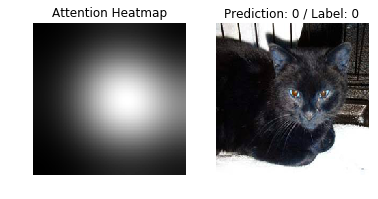

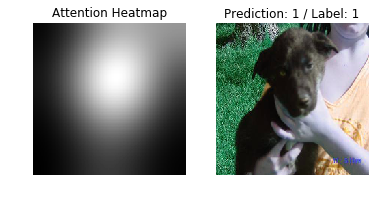

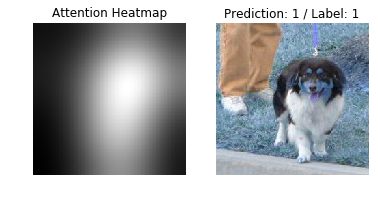

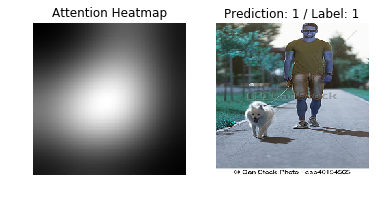

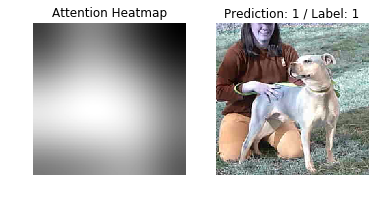

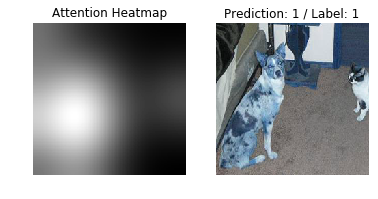

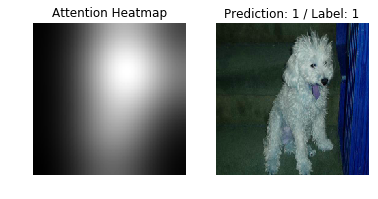

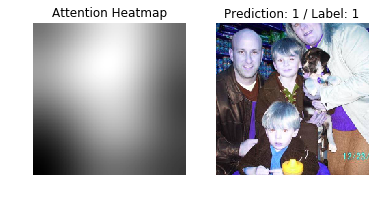

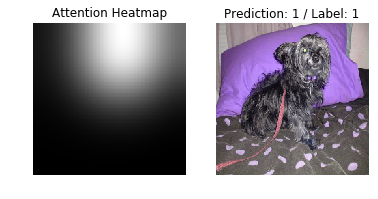

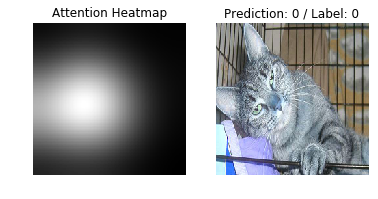

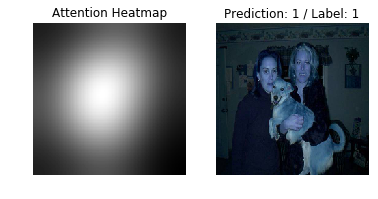

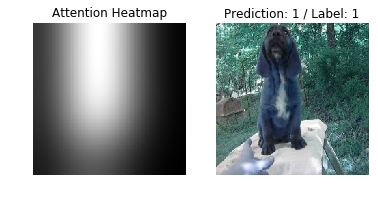

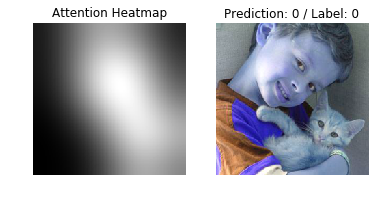

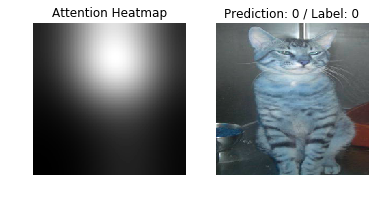

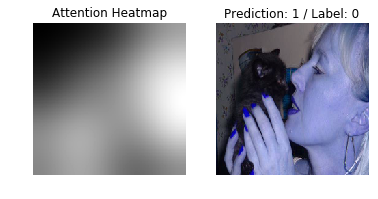

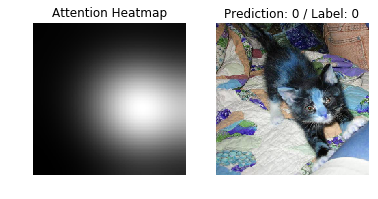

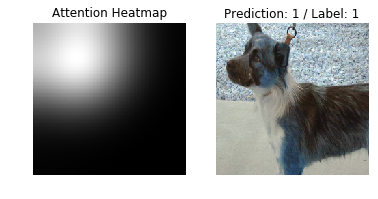

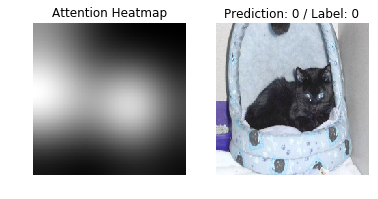

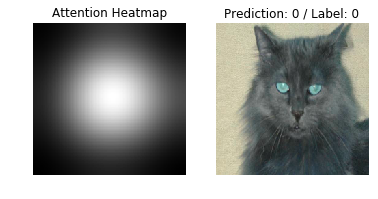

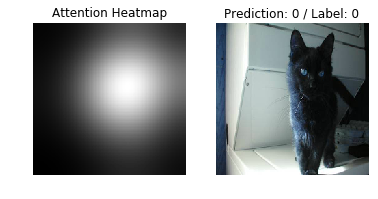

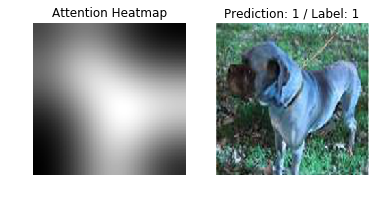

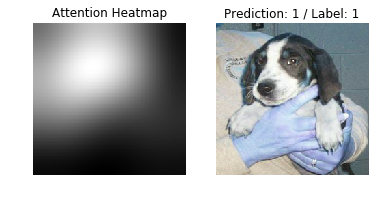

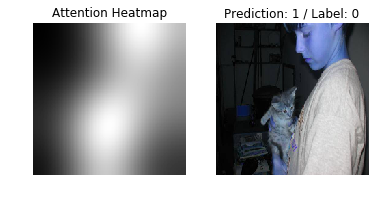

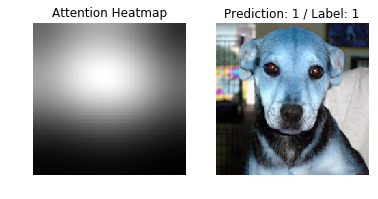

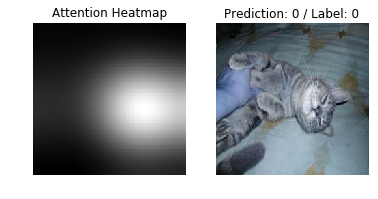

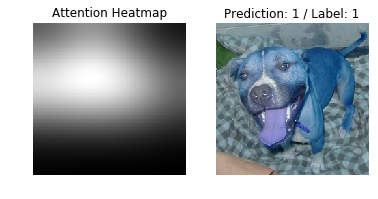

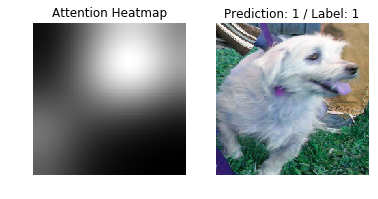

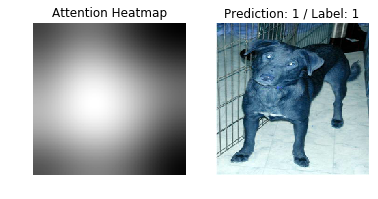

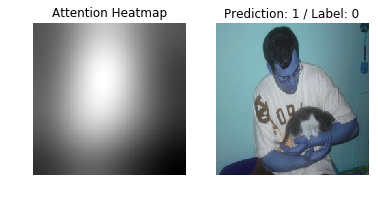

Sample Accuracy: 0.9142857142857143


In [56]:
# Sampling test indexes
idx = random.sample(range(test_x.shape[0]), num_test_sample)

# Initialize fraction of test images and heatmap
test_fraction = np.zeros([10, img_size, img_size, 3])
heat_map = np.zeros([num_test_sample, img_size, img_size])

num_correct = 0.

# Test for Sampling data
for idx_sample in range(num_test_sample):
    
    # Get alpha(weight of fractions) and output for sample test data
    test_x_reshape = np.reshape(test_x, ([test_x.shape[0],img_size,img_size,3]))
    test_x_in = test_x_reshape[idx[idx_sample],:,:,:]
    alpha_, output_ = sess.run([alpha, output],feed_dict = {x_image: [test_x_in], y_target: [test_y[idx[idx_sample],:]]})
    alpha_size = int(np.sqrt(alpha_.shape[1]))
    alpha_reshape = np.reshape(alpha_, (alpha_size, alpha_size))
    alpha_resize = skimage.transform.pyramid_expand(alpha_reshape, upscale = 16, sigma=20)  
    
    # Make heatmap with alpha

    # Get labels for test samples
    y_test_pred = np.argmax(output_[:])
    y_test_true = np.argmax(test_y[idx[idx_sample], :])
    
    # Draw subplot for each sample 
    f1, ax = plt.subplots(1,2)
    ax[0].imshow(alpha_resize, cmap='gray')
    ax[0].axis("off")
    ax[0].set_title('Attention Heatmap')
    ax[1].imshow(test_x[idx[idx_sample],:,:], cmap='gray')
    ax[1].axis("off")
    ax[1].set_title('Prediction: ' + str(y_test_pred) + ' / ' + 'Label: ' + str(y_test_true))

    # Count correct
    if y_test_pred == y_test_true:
        num_correct += 1.

# Show results 
plt.show()
print('Sample Accuracy: ' + str(num_correct / num_test_sample))

In [58]:
alpha_

array([[0.01820393, 0.01600317, 0.0154984 , 0.01465587, 0.01475855,
        0.0254194 , 0.01549992, 0.01808387, 0.01326673, 0.03245433,
        0.07237349, 0.01088543, 0.01341389, 0.01872941, 0.01880026,
        0.01237572, 0.02174515, 0.07347342, 0.01284187, 0.01098158,
        0.01315574, 0.01880743, 0.01357727, 0.03540145, 0.02611308,
        0.01086712, 0.02490272, 0.01046732, 0.01937589, 0.01269661,
        0.06655011, 0.02285572, 0.04032942, 0.02139229, 0.01133041,
        0.01706155, 0.01113693, 0.04231973, 0.01255946, 0.01690391,
        0.01141687, 0.01093944, 0.01302057, 0.01097752, 0.01264559,
        0.01173139, 0.01130499, 0.01033945, 0.01035568]], dtype=float32)

In [45]:
TEST_DIR = 'test2/' 
testing  = [TEST_DIR+i for i in os.listdir(TEST_DIR)]


In [46]:
x,y  = prepare_data(testing)

In [47]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [48]:
image_test_y = to_categorical(y)


In [49]:
num_test_sample=35

C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


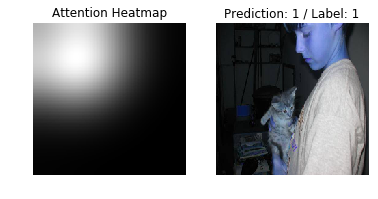

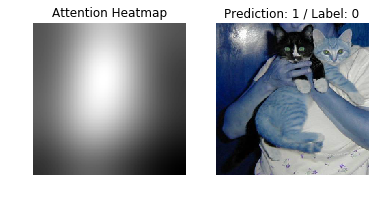

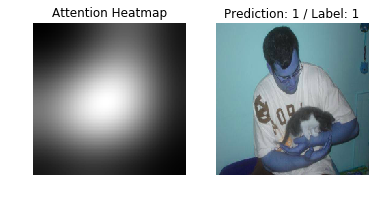

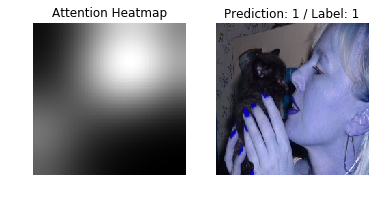

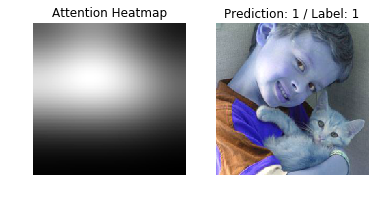

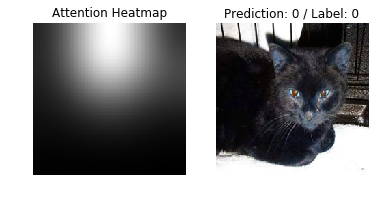

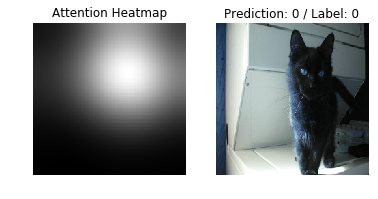

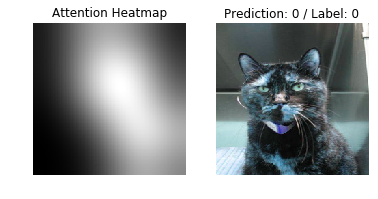

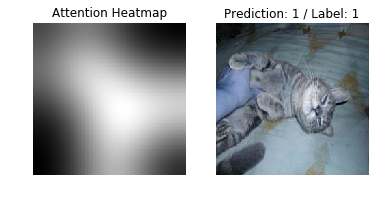

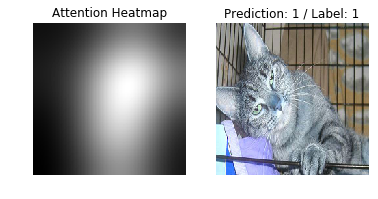

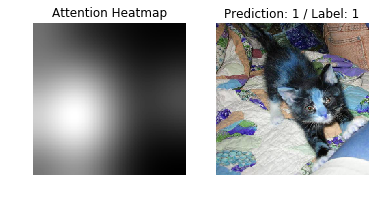

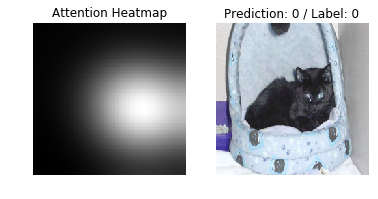

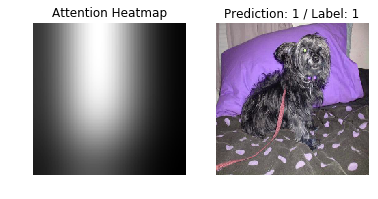

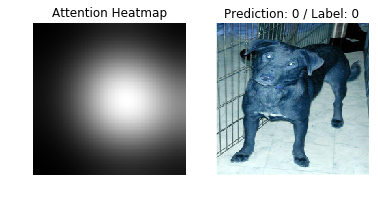

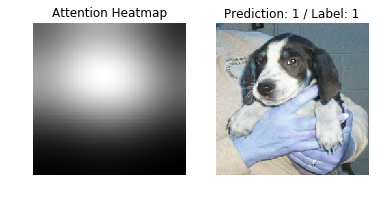

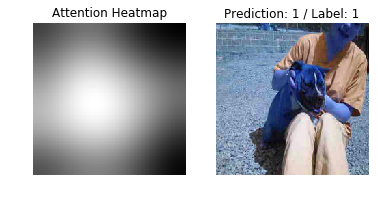

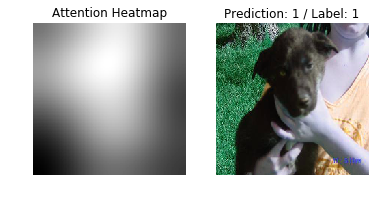

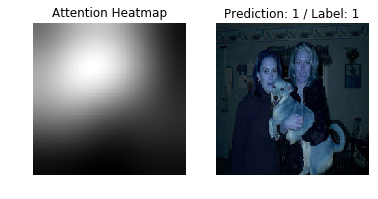

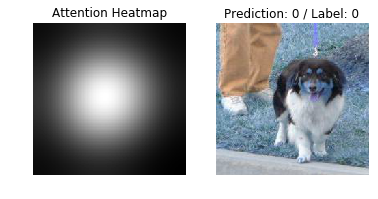

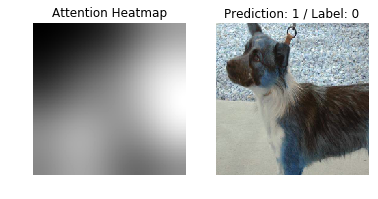

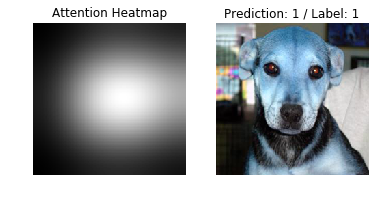

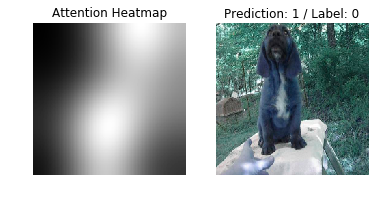

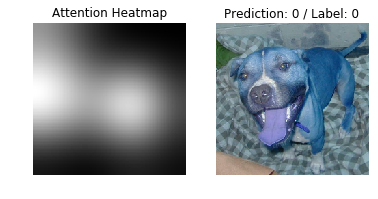

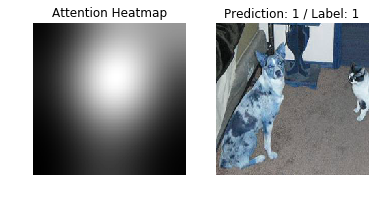

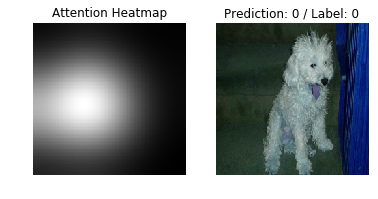

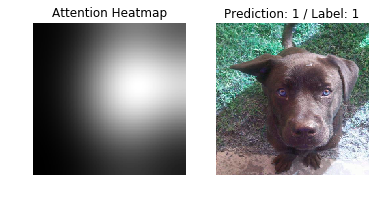

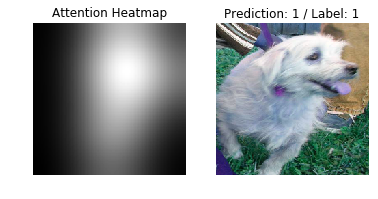

Sample Accuracy: 0.9142857142857143


In [50]:
idx = random.sample(range(x.shape[0]), num_test_sample)

# Initialize fraction of test images and heatmap
test_fraction = np.zeros([35, img_size, img_size, 3])
heat_map = np.zeros([num_test_sample, img_size, img_size])

num_correct = 0.

# Test for Sampling data
for idx_sample in range(num_test_sample):
    
    
    
    test_x_reshape = np.reshape(x, ([x.shape[0],img_size,img_size,3]))
    test_x_in = test_x_reshape[idx[idx_sample],:,:,:]
    
    
        #image_test2 = np.reshape(X[idx_sample], [1,224,224,3])
    alpha_, output_ = sess.run([alpha, output],feed_dict = {x_image: [test_x_in], y_target: [image_test_y[idx[idx_sample],:]]})
    alpha_size = int(np.sqrt(alpha_.shape[1]))
    alpha_reshape = np.reshape(alpha_, (alpha_size, alpha_size))
    alpha_resize = skimage.transform.pyramid_expand(alpha_reshape, upscale = 16, sigma=20)  

    # Make heatmap with alpha

    # Get labels for test samples
    y_test_pred = np.argmax(output_)
    y_test_true = np.argmax(image_test_y[idx[idx_sample], :])

    # Draw subplot for each sample 
    f1, ax = plt.subplots(1,2)
    ax[0].imshow(alpha_resize, cmap='gray')
    ax[0].axis("off")
    ax[0].set_title('Attention Heatmap')
    ax[1].imshow(x[idx_sample],cmap='gray')
    ax[1].axis("off")
    ax[1].set_title('Prediction: ' + str(y_test_pred) + ' / ' + 'Label: ' + str(y_test_true))


    # Count correct
    if y_test_pred == y_test_true:
        num_correct += 1.

# Show results 
plt.show()
print('Sample Accuracy: ' + str(num_correct / num_test_sample))

In [ ]:
alpha_